---
**Copyright 2026 Adilkhan Salkimbayev**  
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at [apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0).
---
 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

AREAS = np.array([28.0, 32.0, 28.0, 32.0]) # Cross sections
a = np.array([0.071, 0.057, 0.071, 0.057])
g = 981.0 # cm/s^2
gamma = np.array([0.43, 0.34]) # Valve ratios
x_true = np.array([12.4, 12.7, 1.8, 1.4]) # initial heights
k_pump = np.array([3.14, 3.29])
dt = 0.1
SERIAL_PORT = 'COM5'

In [2]:
def physics_nonlinear_model(x, u, dt):
    """
    Computes the NEXT state given current state x and input u.
    x: [h1, h2, h3, h4]
    u: [v1, v2] (Pump voltages)
    """
    x = x.flatten()
    h1, h2, h3, h4 = x
    v1, v2 = u
    
    # Avoid sqrt(negative) or division by zero
    h1 = max(h1, 0.001)
    h2 = max(h2, 0.001)
    h3 = max(h3, 0.001)
    h4 = max(h4, 0.001)

    k1 = float(k_pump[0])
    k2 = float(k_pump[1])

    # Johansson Equations
    # dh1/dt = ...
    dh1 = - (a[0]/AREAS[0]) * np.sqrt(2*g*h1) + (a[2]/AREAS[0]) * np.sqrt(2*g*h3) + (gamma[0]*k1*v1)/AREAS[0]
    dh2 = - (a[1]/AREAS[1]) * np.sqrt(2*g*h2) + (a[3]/AREAS[1]) * np.sqrt(2*g*h4) + (gamma[1]*k2*v2)/AREAS[1]
    dh3 = - (a[2]/AREAS[2]) * np.sqrt(2*g*h3) + ((1-gamma[1])*k2*v2)/AREAS[2]
    dh4 = - (a[3]/AREAS[3]) * np.sqrt(2*g*h4) + ((1-gamma[0])*k1*v1)/AREAS[3]

    # Euler Integration (Simple enough for simulation)
    x_next = np.array([
        h1 + dh1 * dt,
        h2 + dh2 * dt,
        h3 + dh3 * dt,
        h4 + dh4 * dt
    ])
    return x_next

In [3]:
def get_jacobian_F(x, u, dt):
    """
    Returns the 4x4 Jacobian Matrix F linearized at point x.
    x_k+1 approx F * x_k
    """
    x_safe = np.array(x).flatten()
    h_grad = np.maximum(x_safe, 1.0) 
    # ... Insert your partial derivatives here ...
    # Remember: Discrete F = I + A_continuous * dt
    F = np.eye(4);

    A1, A2, A3, A4 = float(AREAS[0]), float(AREAS[1]), float(AREAS[2]), float(AREAS[3])
    a1, a2, a3, a4 = float(a[0]), float(a[1]), float(a[2]), float(a[3])
    g_val = float(g)
    
    df1_dh1 = -(a[0]/A1) * np.sqrt(g_val/(2*h_grad[0]))
    F[0,0] = 1 + dt * df1_dh1

    df2_dh2 = -(a[1]/A2) * np.sqrt(g_val/(2*h_grad[1]))
    F[1,1] = 1 + dt * df2_dh2;

    df3_dh3 = -(a[2]/A3) * np.sqrt(g_val/(2*h_grad[2]))
    F[2,2] = 1 + dt * df3_dh3; 

    df4_dh4 = -(a[3]/A4) * np.sqrt(g_val/(2*h_grad[3]))
    F[3,3] = 1 + dt * df4_dh4

    df1_dh3 = (a[2]/A1) * np.sqrt(g_val/(2*h_grad[2]))
    F[0,2] = dt * df1_dh3

    df2_dh4 = (a[3]/A2) * np.sqrt(g_val/(2*h_grad[3]))
    F[1,3] = dt * df2_dh4
                       
    return F

In [4]:
def get_linear_model_affine(x_op, u_op, dt):
    """
    Returns A, B, d using the GLOBAL physical constants.
    """
    # 1. Get Jacobian F (A matrix)
    # Ensure this function also uses the global 'a' and 'AREAS'
    A_lin = get_jacobian_F(x_op, u_op, dt)
    
    # 2. Define B (Input Matrix)
    B_lin = np.zeros((4, 2))
    
    # Extract Globals (Safely cast to float)
    A1, A2, A3, A4 = float(AREAS[0]), float(AREAS[1]), float(AREAS[2]), float(AREAS[3])
    g1, g2 = float(gamma[0]), float(gamma[1])
    k1, k2 = float(k_pump[0]), float(k_pump[1]) 
    
    # Pump 1 (v1) -> Tank 1 & Tank 4
    B_lin[0, 0] = dt * (g1 * k1 / A1)       
    B_lin[3, 0] = dt * ((1 - g1) * k1 / A4) 
    
    # Pump 2 (v2) -> Tank 2 & Tank 3
    B_lin[1, 1] = dt * (g2 * k2 / A2)       
    B_lin[2, 1] = dt * ((1 - g2) * k2 / A3) 
    
    # 3. Calculate Affine Offset d
    # This captures the "Gravity Drain" that A*x + B*u misses
    x_lin = A_lin @ x_op + B_lin @ u_op
    x_nonlin = physics_nonlinear_model(x_op, u_op, dt)
    d = x_nonlin - x_lin
    
    return A_lin, B_lin, d

In [3]:
import cvxpy as cp

    # Q: Penalty for state error. High values = strict tracking.
    # R: Penalty for input effort. High values = save electricity/smooth inputs.
Q_mpc = np.diag([40, 40, 5, 5]) 
R_mpc = np.diag([0.001, 0.001])

def solve_mpc_affine(x0, A_lin, B_lin, d, target, horizon=30):
    """
    Solves the QP problem to find the optimal input u.
    x0: Current EKF estimate
    target: Desired state [h1_ref, h2_ref, h3_ref, h4_ref]
    """
    # Dimensions
    n_x = 4
    n_u = 2
    
    # Variables for the optimization horizon
    x = cp.Variable((n_x, horizon + 1))
    u = cp.Variable((n_u, horizon))
    
    cost = 0
    x0_safe = np.maximum(x0, 0.0)
    constraints = [x[:,0] == x0_safe]
    
    # 1. Start at the current estimate
    constraints += [x[:, 0] == x0]
       
    
    for k in range(horizon):
        # COST FUNCTION
        # Minimize (error^2 * Q) + (input^2 * R)
        cost += cp.quad_form(x[:, k] - target, Q_mpc)
        cost += cp.quad_form(u[:, k], R_mpc)
        
        # DYNAMICS CONSTRAINT
        # x(k+1) = A*x(k) + B*u(k) + d
        constraints += [x[:, k+1] == A_lin @ x[:, k] + B_lin @ u[:, k] + d]
        
        # INPUT CONSTRAINTS (Actuator Limits)
        constraints += [u[:, k] >= 0.0]  # Pumps can't suck water back
        constraints += [u[:, k] <= 12.0] # Max 12 Volts
        
        # STATE CONSTRAINTS (Safety)
        constraints += [x[:, k+1] >= 0.0]  # Empty
        constraints += [x[:, k+1] <= 40.0] # Overflow limit (cm)

    # SOLVE
    prob = cp.Problem(cp.Minimize(cost), constraints)
    #output_dir = 'Nucleo_MPC_Gen_Dense_Finale'
    #cpg.generate_code(prob, code_dir=output_dir, solver='OSQP')
    #print(f"✅ Generated in {output_dir}")
    
    # OSQP is a great solver for embedded-style problems
    prob.solve(solver=cp.OSQP, warm_start=True)
    
    # Return the first input of the sequence
    if u.value is None:
        print("MPC Failed: Infeasible!")
        return np.array([0.0, 0.0])
    
    # .value returns a numpy array, we take the first column
    return u.value[:, 0]

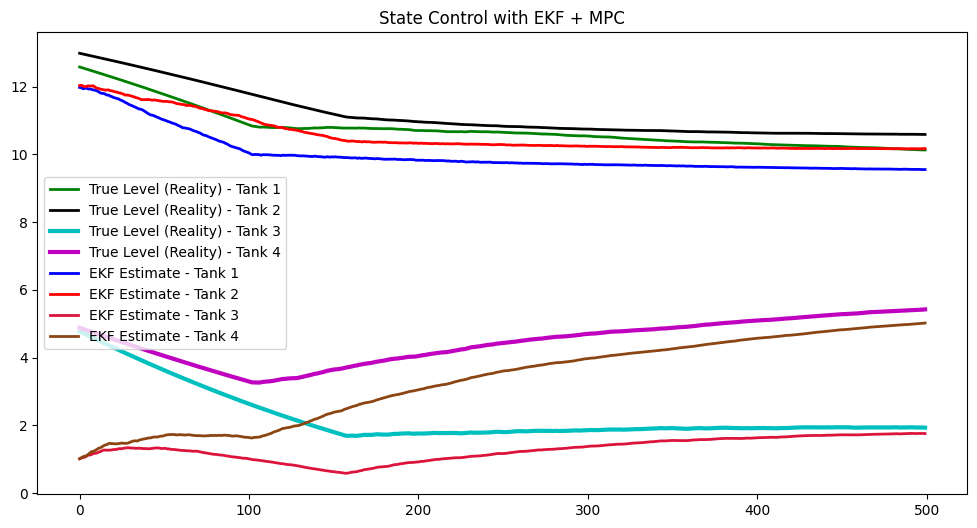

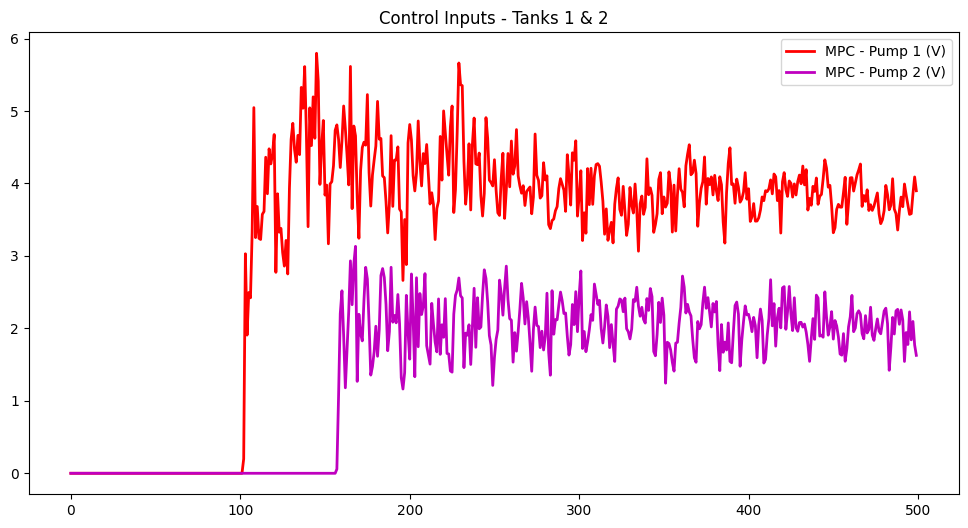

In [6]:
# --- 1. SETUP ---
dt = 0.1          # Time step (seconds)
T_max = 50.0      # Total duration
steps = int(T_max / dt)

# A. SIMULATION PARAMETERS (The "Truth")
# The actual sensor is decent. Variance ~2.37
R_sim_val = 2.37
R_sim = np.eye(4) * R_sim_val 

# The actual water doesn't jump. Process noise is tiny.
Q_sim = np.eye(4) * 1e-6 

# B. EKF TUNING PARAMETERS (The "Filter")
# We lie to the EKF. We tell it the sensor is terrible so it smooths the data.
R_ekf = np.eye(4) * 100.0  # High smoothing
Q_ekf = np.eye(4) * 1e-4   # Trust model

# C. INITIALIZATION
x_true = np.array([12.6, 13.0, 4.8, 4.9])
x_est = np.array([12.0, 12.0, 1.0, 1.0]) 
P = np.eye(4) * 1.0 # Lower initial uncertainty to prevent startup explosion
H = np.eye(4)
u = np.array([0.0, 0.0]) # starting voltage

target_state = np.array([10.0, 10.0, 2.0, 2.0])

# History for plotting
history_true = []
history_est = []
#history_meas = []
history_u = []

# --- 2. THE LOOP ---
for k in range(steps):
    
    # A. DEFINE INPUTS

   # 1. Clamp state for Solver Safety
    x_for_mpc = np.maximum(x_est, 0.0)

    # 2. Get Affine Model
    A_lin, B_lin, d_lin = get_linear_model_affine(x_for_mpc, u, dt)

    # 3. Solve (let it crash if it fails)
    u_optimal = solve_mpc_affine(x_for_mpc, A_lin, B_lin, d_lin, target_state)
    u = u_optimal

    history_u.append(u)

    # 2. Physics evolves
    x_true = physics_nonlinear_model(x_true, u, dt)
    
    # 3. Add Process Noise (Simulating turbulence/leaks)
    w = np.random.multivariate_normal([0]*4, Q_sim) 
    x_true += w * dt # (Technically integrated noise)
    
    # 4. Generate Measurements (Sensors)
    v = np.random.multivariate_normal([0]*4, R_sim)
    z_measurement = x_true + v # This is what the STM32 "reads" via ADC

    # C. RUN EKF (The Algorithm)
    # --- PREDICT STEP ---
    # 1. Predict state using nonlinear model (Euler integration step)
    x_pred = physics_nonlinear_model(x_est, u, dt)
    
    # 2. Predict Covariance: P = F * P * F.T + Q
    F = get_jacobian_F(x_est, u, dt)
    P_pred = F @ P @ F.T + Q_ekf

    # --- UPDATE STEP ---
    # 3. Calculate Innovation (Measurement Residual)
    y_residual = z_measurement - H @ x_pred 
    
    # 4. Kalman Gain: K = P * H.T * inv(H * P * H.T + R)
    S = H @ P_pred @ H.T + R_ekf
    K = P_pred @ H.T @ np.linalg.inv(S)
    
    # 5. Update Estimate
    x_est = (x_pred + (K @ y_residual)).flatten()
    
    # 6. Update Covariance
    P = (np.eye(4) - K @ H) @ P_pred
    
    # Save Data
    history_true.append(x_true)
    history_est.append(x_est)
    #history_meas.append(z_measurement)

# --- 3. VISUALIZATION ---
hist_true = np.array(history_true)
hist_est = np.array(history_est)
#hist_meas = np.array(history_meas)
hist_u = np.array(history_u)

plt.figure(figsize=(12, 6))
plt.plot(hist_true[:,0], 'g-', linewidth=2, label='True Level (Reality) - Tank 1')
plt.plot(hist_true[:,1], 'k-', linewidth=2, label='True Level (Reality) - Tank 2')
plt.plot(hist_true[:,2], 'c-', linewidth=3, label='True Level (Reality) - Tank 3')
plt.plot(hist_true[:,3], 'm-', linewidth=3, label='True Level (Reality) - Tank 4')
plt.plot(hist_est[:,0], 'b-', linewidth=2, label='EKF Estimate - Tank 1')
plt.plot(hist_est[:,1], 'r-', linewidth=2, label='EKF Estimate - Tank 2')
plt.plot(hist_est[:,2], color='crimson', linewidth=2, label='EKF Estimate - Tank 3')
plt.plot(hist_est[:,3], color='saddlebrown', linewidth=2, label='EKF Estimate - Tank 4')
plt.title("State Control with EKF + MPC")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(hist_u[:,0], 'r-', linewidth=2, label='MPC - Pump 1 (V)')
plt.plot(hist_u[:,1], 'm-', linewidth=2, label='MPC - Pump 2 (V)')
plt.title("Control Inputs - Tanks 1 & 2")
plt.legend()
plt.show()

In [7]:
import pandas as pd

# Create a structured DataFrame
# We save EVERYTHING so you can debug specific parts of the C code later
df_export = pd.DataFrame({
    'time_sec': np.arange(steps) * dt,
    
    # The Truth (Physics)
    'h1_true': np.array(history_true)[:, 0],
    'h2_true': np.array(history_true)[:, 1],
    'h3_true': np.array(history_true)[:, 2],
    'h4_true': np.array(history_true)[:, 3],
    
    # The Estimate (EKF) - Critical for debugging your C EKF
    'h1_est': np.array(history_est)[:, 0],
    'h2_est': np.array(history_est)[:, 1],
    'h3_est': np.array(history_est)[:, 2],
    'h4_est': np.array(history_est)[:, 3],
    
    # The Measurements (Simulated ADC readings) - will feed these into the C code
    
    # The Output (MPC) - Critical for debugging your C Solver
    'u1_volts': np.array(history_u)[:, 0],
    'u2_volts': np.array(history_u)[:, 1]
})

# Save to CSV
filename = 'quad_tank_golden_reference_P_minus.csv' # or P_minus.csv
df_export.to_csv(filename, index=False, float_format='%.6f')

print(f"✅ Simulation data saved to {filename}")
print("Use this file to validate Nucleo C code!")

✅ Simulation data saved to quad_tank_golden_reference_P_minus.csv
Use this file to validate Nucleo C code!


In [8]:
import control as ct

C = np.zeros((2, 4))
C[0,0] = 0.5
C[1,1] = 0.5

A_lin, B_lin, d_lin = get_linear_model_affine(x_for_mpc, u, dt)
C_ctrb = ct.ctrb(A_lin, B_lin)
rank_C_ctrb = np.linalg.matrix_rank(C_ctrb)

O_obsv = ct.obsv(A_lin, C)
rank_O_obsv = np.linalg.matrix_rank(O_obsv)

n_matrix = A_lin.shape[0]

if rank_C_ctrb == n_matrix and rank_O_obsv == n_matrix:
    print("System is controllable and observable!")

System is controllable and observable!


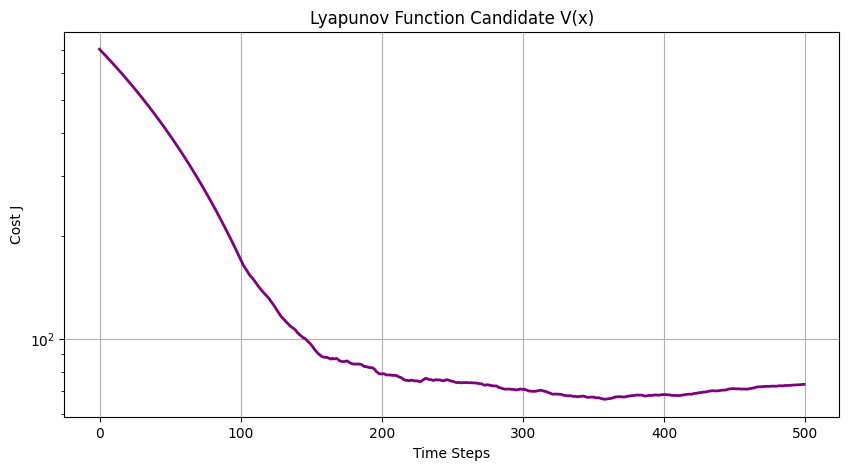

In [9]:
# Lyapunov Function (Cost) over time
lyapunov_history = []

for k in range(len(history_true)):
    x_err = history_true[k] - target_state
    
    # technically u_err = u - u_steady, but u itself is fine for showing convergence
    u_val = history_u[k] 
    
    # J = x^TQx + u^TRu
    cost_x = x_err.T @ Q_mpc @ x_err
    cost_u = u_val.T @ R_mpc @ u_val
    
    V_k = cost_x + cost_u
    lyapunov_history.append(V_k)

plt.figure(figsize=(10, 5))
plt.plot(lyapunov_history, linewidth=2, color='purple')
plt.title("Lyapunov Function Candidate V(x)")
plt.xlabel("Time Steps")
plt.ylabel("Cost J")
plt.grid()
plt.yscale('log') 
plt.show()

Running KAN Control Loop...


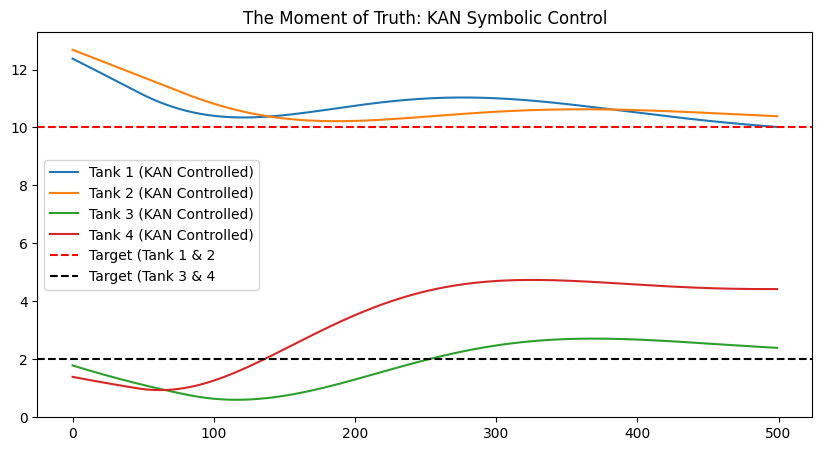

In [5]:
# --- THE FINAL VERIFICATION ---
# KAN vs Physics (No MPC Solver involved)
dt = 0.1          # Time step (seconds)
T_max = 50.0      # Total duration
steps = int(T_max / dt)
def get_kan_control_P_plus(x, target):
    x_norm = x / 20.0
    err_norm = (target - x) / 20.0
    
    # Unpack for clarity (x1=h1, x5=e1, etc.)
    x_1, x_2, x_3, x_4 = x_norm[0], x_norm[1], x_norm[2], x_norm[3]
    x_5, x_6, x_7, x_8 = err_norm[0], err_norm[1], err_norm[2], err_norm[3]
    
    term_gravity = -10.0001583099365*x_1 - 9.9999303817749
    quad_term = 0.025617322294888 * (term_gravity**2)
    u1_raw = -0.0968267150455004*x_1 - 11.5522264852875*x_2 + 0.24044993223655*x_3 - 1.44435744660287*x_4 + 3.84138434219758*x_5 + 0.391351450674539*x_7 - 0.0423460680693187*x_8 + 0.025617322294888*(-10.0001583099365*x_1 - 9.9999303817749)**2 - 0.0544665046036243*(-1.67091600341674*x_1 + 3.95226181130601*x_3 - 3.95791483032078*x_4 + 0.0593229825848618*x_8 - 1.27748664741404)**2 + 1.17289172290718
    
    u2_raw = 0.255779834040008*x_1 - 2.6622473754427*x_2 + 0.507210095953869*x_3 - 0.526471928427408*x_4 + 0.555851813772936*x_5 + 0.0940461332965534*x_7 - 0.0233986858247011*x_8 + 0.00577475079669435*(-10.0001583099365*x_1 - 9.9999303817749)**2 + 0.0999103412032127*(-1.67086166413561*x_1 + 3.95213328116732*x_3 - 3.9577861163422*x_4 + 0.0593210533626737*x_8 - 1.27916169855622)**2 - 0.470107100576432
    
    u = np.array([u1_raw, u2_raw]) * 12.0
    
    return np.clip(u, 0.0, 12.0)

x_test = np.array([12.4, 12.7, 1.8, 1.4]) # put P+ numbers for NMP control
target = np.array([10.0, 10.0, 2.0, 2.0])
history_kan = []
voltage_kan = []

print("Running KAN Control Loop...")
for k in range(500):
    u_kan = get_kan_control_P_plus(x_test, target)
    voltage_kan.append(u_kan)
    
    x_test = physics_nonlinear_model(x_test, u_kan, dt)
    history_kan.append(x_test)

# 3. Plot
res_kan = np.array(history_kan)
plt.figure(figsize=(10,5))
plt.plot(res_kan[:,0], label='Tank 1 (KAN Controlled)')
plt.plot(res_kan[:,1], label='Tank 2 (KAN Controlled)')
plt.plot(res_kan[:,2], label='Tank 3 (KAN Controlled)')
plt.plot(res_kan[:,3], label='Tank 4 (KAN Controlled)')
plt.axhline(10.0, color='r', linestyle='--', label='Target (Tank 1 & 2')
plt.axhline(2.0, color='k', linestyle='--', label='Target (Tank 3 & 4')
plt.legend()
plt.title("The Moment of Truth: KAN Symbolic Control")
plt.show()

In [11]:
import pandas as pd

df_export = pd.DataFrame({
    "time_sec": np.arange(steps) * dt,

    'h1_kan': np.array(history_kan)[:,0],
    'h2_kan': np.array(history_kan)[:,1],
    'h3_kan': np.array(history_kan)[:,2],
    'h4_kan': np.array(history_kan)[:,3],

    'u1_kan': np.array(voltage_kan)[:,0],
    'u2_kan': np.array(voltage_kan)[:,1]
})

filename = 'quad_tank_KAN_P_minus_NMP_training.csv'
df_export.to_csv(filename, index=False, float_format='%.6f')

print(f"✅ Simulation data saved to {filename}")

✅ Simulation data saved to quad_tank_KAN_P_minus_NMP_training.csv


Running P- KAN Control Loop...


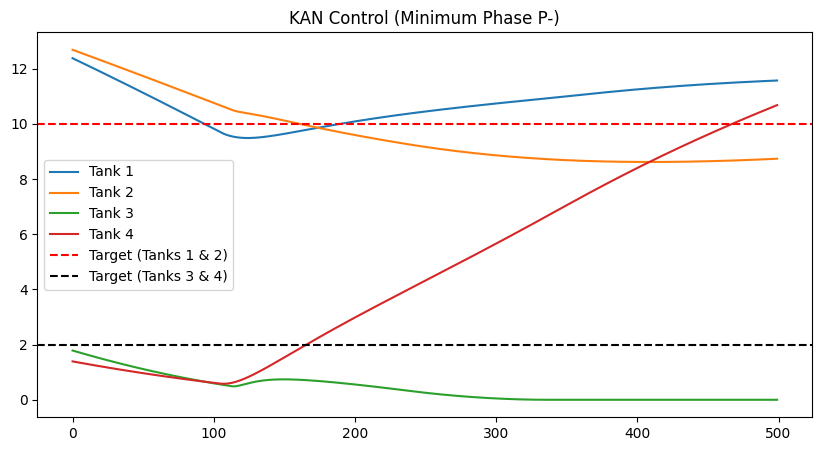

In [12]:
# --- KAN P- (MINIMUM PHASE) VERIFICATION ---

def get_kan_control_P_minus(x, target):
    # 1. Normalize (Match training!)
    x_norm = x / 20.0
    err_norm = (target - x) / 20.0
    
    # Unpack (x_1..x_4 are states, x_5..x_8 are errors)
    x_1, x_2, x_3, x_4 = x_norm[0], x_norm[1], x_norm[2], x_norm[3]
    x_5, x_6, x_7, x_8 = err_norm[0], err_norm[1], err_norm[2], err_norm[3]
    
    # --- PUMP 1 FORMULA ---
    # -7.51*x1 + ... + Quadratic(x7) + 4.33
    u1_raw = -7.51353229127572*x_1 + 1.67695980545613*x_2 + 1.380334825995*x_3 + 1.41885837254108*x_4 + 13.5659177492177*x_5 + 12.9515220240303*x_6 + 0.00379216831156005*x_7 - 1.86035150507028*x_8 - 0.0111200432541076*(-9.99997997283936*x_7 - 10.0)**2 + 4.32878089027349

    # --- PUMP 2 FORMULA ---
    # 29.55*x1 ... + Quadratic(x7) - 16.11
    # Note: Same quadratic term base (-10*x7 - 10)
    u2_raw = 29.5483484887791*x_1 - 6.28340398110346*x_2 - 5.79130579228489*x_3 - 6.12823903142176*x_4 + 53.3293360232067*x_5 + 50.5462118426809*x_6 - 0.326246124210953*x_7 + 9.99471715160938*x_8 + 0.0438193227065643*(-9.99997997283936*x_7 - 10.0)**2 - 16.1091995441476

    u = np.array([u1_raw, u2_raw]) * 12.0
    return np.clip(u, 0.0, 12.0)

x_test = np.array([12.4, 12.7, 1.8, 1.4]) # Johansson's P- data 
target = np.array([10.0, 10.0, 2.0, 2.0])
hist_kan = []
volt_kan = []

print("Running P- KAN Control Loop...")
for k in range(500):
    u_kan = get_kan_control_P_minus(x_test, target)
    volt_kan.append(u_kan)
    
    x_test = physics_nonlinear_model(x_test, u_kan, dt) # Ensure physics uses P- constants!
    hist_kan.append(x_test)

# Plot
res = np.array(hist_kan)
plt.figure(figsize=(10,5))
plt.plot(res[:,0], label='Tank 1')
plt.plot(res[:,1], label='Tank 2')
plt.plot(res[:,2], label='Tank 3')
plt.plot(res[:,3], label='Tank 4')
plt.axhline(10.0, color='r', linestyle='--', label='Target (Tanks 1 & 2)')
plt.axhline(2, color='k', linestyle='--', label='Target (Tanks 3 & 4)')
plt.legend()
plt.title("KAN Control (Minimum Phase P-)")
plt.show()

In [13]:
import pandas as pd

df_export = pd.DataFrame({
    "time_sec": np.arange(steps) * dt,

    'h1_kan': np.array(hist_kan)[:,0],
    'h2_kan': np.array(hist_kan)[:,1],
    'h3_kan': np.array(hist_kan)[:,2],
    'h4_kan': np.array(hist_kan)[:,3],

    'u1_kan': np.array(volt_kan)[:,0],
    'u2_kan': np.array(volt_kan)[:,1]
})

filename = 'quad_tank_KAN_P_minus_MP_training.csv'
df_export.to_csv(filename, index=False, float_format='%.6f')

print(f"✅ Simulation data saved to {filename}")

✅ Simulation data saved to quad_tank_KAN_P_minus_MP_training.csv


In [ ]:
import struct
import serial
import time
import matplotlib.pyplot as plt

dt_hil = 0.003
total_time = 50.0 # seconds
steps = int(total_time / dt_hil) # 16,666 steps

# 'ffff' means 4 floats (little endian)
# The Nucleo is usually Little Endian.
packer = struct.Struct('<ffff') 
unpacker = struct.Struct('<fff')
ser = serial.Serial(SERIAL_PORT, 921600, timeout=1.0) 
print(f"✅ Connected to {ser.name}")

def send_state(ser, state_vector):
    # Add a header byte (e.g., 0xA5) so the Nucleo knows where the packet starts
    packet = b'\xA5' + packer.pack(*state_vector)
    ser.write(packet)

def receive_control_with_time(ser):
    # Read 12 bytes (3 floats)
    data = ser.read(12)
    if len(data) == 12:
        return unpacker.unpack(data)
    return (0.0, 0.0, 0.0)

# --- HIL CONTROL LOOP ---
# This replaces the internal Python calculation with the Nucleo's answer

x_test = np.array([12.6, 13.0, 4.8, 4.9]) # Start State
history_hil = []
control_history = []
exec_time = []

print("Starting Hardware-in-the-Loop Simulation...")

try:
    # Open Port (if not already open)
    if not ser.is_open:
        ser.open()
        
    for k in range(steps):
        # 1. Send State to Nucleo
        # Nucleo calculates: EKF -> KAN -> Clamp -> u
        send_state(ser, x_test)
        
        # 2. Receive Control from Nucleo
        u_nucleo = receive_control_with_time(ser)
        
        # 3. Simulate Physics (Python side)
        # We use the voltage DECIDED by the Nucleo to evolve the physics
        u1, u2, t_exec = u_nucleo
        u_applied = np.array([u1, u2])
        x_test = physics_nonlinear_model(x_test, u_applied, dt_hil)
        
        # Store data
        history_hil.append(x_test)
        control_history.append(u_applied)
        exec_time.append(t_exec)
        
        if k % 1000 == 0:
            print(f"Step {k}: h1={x_test[0]:.2f}, h2={x_test[1]:.2f}, h3={x_test[2]:.2f}, h4={x_test[3]:.2f}, u={u_applied}, execution_time={t_exec}")
    history_hilc = np.array(history_hil)
    control_historyc = np.array(control_history)
    print("HIL Complete.")
    plt.figure(figsize=(12, 6))
    plt.plot(history_hilc[:,0], label='Tank 1')
    plt.plot(history_hilc[:,1], label='Tank 2')
    plt.plot(history_hilc[:,2], label='Tank 3')
    plt.plot(history_hilc[:,3], label='Tank 4')
    plt.axhline(10.0, color='r', linestyle='--', label='Target (Tanks 1 & 2)')
    plt.axhline(2, color='k', linestyle='--', label='Target (Tanks 3 & 4)')
    plt.legend()
    plt.title("KAN Control (Minimum Phase P-)")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(control_historyc[:,0], label='KAN Voltage - Tank 1')
    plt.plot(control_historyc[:,1], label='KAN Voltage - Tank 2')
    plt.legend()
    plt.title("KAN Control (Voltage)")
    plt.show()
    
    ser.close()

except Exception as e:
    print(f"Error: {e}")
    ser.close()

# Plotting code here...

SerialException: could not open port 'COM5': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

✅ Connected to COM5
Starting Hardware-in-the-Loop Simulation...
Step 0: h1=12.60, h2=13.00, h3=4.80, h4=4.90, u=[0. 0.], execution_time=0.0
Step 1000: h1=12.77, h2=12.84, h3=4.41, h4=5.12, u=[0.         0.79836351], execution_time=1.0145833492279053
Step 2000: h1=12.26, h2=12.58, h3=3.86, h4=4.59, u=[0.         0.39570433], execution_time=1.0104166269302368
Step 3000: h1=11.73, h2=12.27, h3=3.29, h4=4.10, u=[0.         0.18556304], execution_time=1.0104166269302368
Step 4000: h1=11.17, h2=11.92, h3=2.73, h4=3.64, u=[0.         0.04600817], execution_time=1.0041667222976685
Step 5000: h1=10.59, h2=11.55, h3=2.20, h4=3.20, u=[0. 0.], execution_time=0.9916666746139526
Step 6000: h1=9.98, h2=11.16, h3=1.73, h4=2.79, u=[0. 0.], execution_time=0.9958333373069763
Step 7000: h1=9.44, h2=10.76, h3=1.32, h4=2.51, u=[1.57680917 0.        ], execution_time=0.9979166388511658
--- [Step 7500] DISTURBANCE INJECTED: h1 + 3.0 cm ---
Step 8000: h1=12.14, h2=10.42, h3=1.08, h4=2.65, u=[5.33297586 1.90721

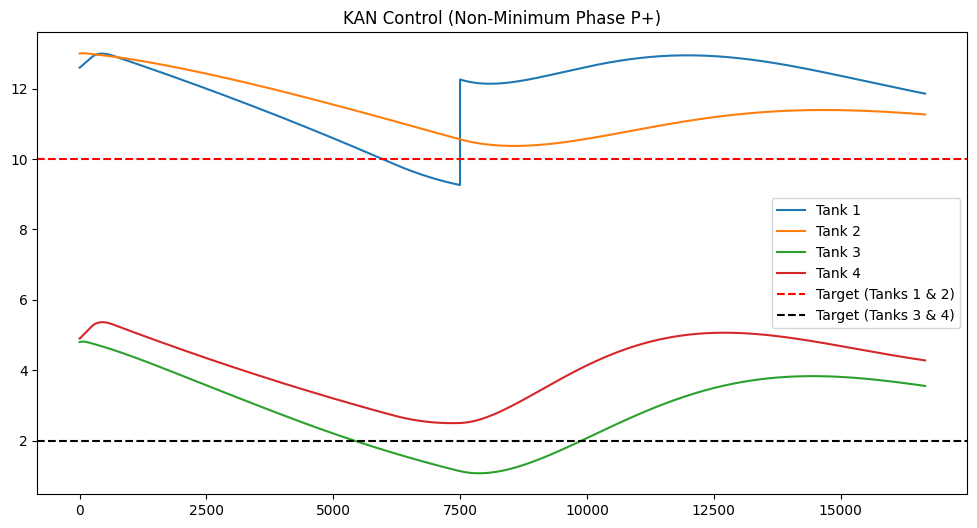

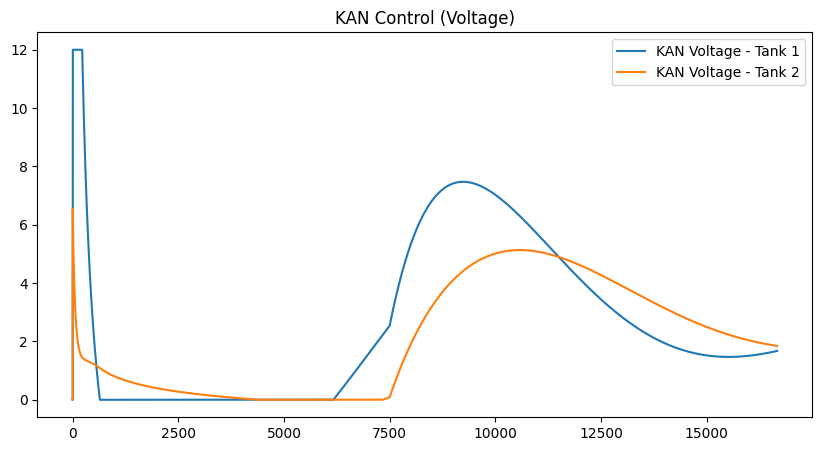

In [ ]:
import struct
import serial
import time
import matplotlib.pyplot as plt

dt_hil = 0.003
total_time = 50.0 # seconds
steps = int(total_time / dt_hil) # 16,666 steps

# 'ffff' means 4 floats (little endian)
# The Nucleo is usually Little Endian.
packer = struct.Struct('<ffff') 
unpacker = struct.Struct('<fff')
ser = serial.Serial(SERIAL_PORT, 921600, timeout=1.0) 
print(f"✅ Connected to {ser.name}")

def send_state(ser, state_vector):
    # Add a header byte (e.g., 0xA5) so the Nucleo knows where the packet starts
    packet = b'\xA5' + packer.pack(*state_vector)
    ser.write(packet)

def receive_control_with_time(ser):
    # Read 12 bytes (3 floats)
    data = ser.read(12)
    if len(data) == 12:
        return unpacker.unpack(data)
    return (0.0, 0.0, 0.0)

# --- HIL CONTROL LOOP ---
# This replaces the internal Python calculation with the Nucleo's answer

x_test = np.array([12.6, 13.0, 4.8, 4.9]) # Start State
history_hil = []
control_history = []
exec_time = []

print("Starting Hardware-in-the-Loop Simulation...")

try:
    # Open Port (if not already open)
    if not ser.is_open:
        ser.open()
        
    for k in range(steps):
        # Disturbance!
        if k == 7500:
            x_test[0] += 3.0
            print(f"--- [Step {k}] DISTURBANCE INJECTED: h1 + 3.0 cm ---")
            
        # 1. Send State to Nucleo
        # Nucleo calculates: EKF -> KAN -> Clamp -> u
        send_state(ser, x_test)
        
        # 2. Receive Control from Nucleo
        u_nucleo = receive_control_with_time(ser)
        
        # 3. Simulate Physics (Python side)
        # We use the voltage DECIDED by the Nucleo to evolve the physics
        u1, u2, t_exec = u_nucleo
        u_applied = np.array([u1, u2])
        x_test = physics_nonlinear_model(x_test, u_applied, dt_hil)
        
        # Store data
        history_hil.append(x_test)
        control_history.append(u_applied)
        exec_time.append(t_exec)
        
        if k % 1000 == 0:
            print(f"Step {k}: h1={x_test[0]:.2f}, h2={x_test[1]:.2f}, h3={x_test[2]:.2f}, h4={x_test[3]:.2f}, u={u_applied}, execution_time={t_exec}")
    history_hilc = np.array(history_hil)
    control_historyc = np.array(control_history)
    print("HIL Complete.")
    plt.figure(figsize=(12, 6))
    plt.plot(history_hilc[:,0], label='Tank 1')
    plt.plot(history_hilc[:,1], label='Tank 2')
    plt.plot(history_hilc[:,2], label='Tank 3')
    plt.plot(history_hilc[:,3], label='Tank 4')
    plt.axhline(10.0, color='r', linestyle='--', label='Target (Tanks 1 & 2)')
    plt.axhline(2, color='k', linestyle='--', label='Target (Tanks 3 & 4)')
    plt.legend()
    plt.title("KAN Control (Non-Minimum Phase P+)")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(control_historyc[:,0], label='KAN Voltage - Tank 1')
    plt.plot(control_historyc[:,1], label='KAN Voltage - Tank 2')
    plt.legend()
    plt.title("KAN Control (Voltage)")
    plt.show()
    
    ser.close()

except Exception as e:
    print(f"Error: {e}")
    ser.close()

# Plotting code here...

In [ ]:
import pandas as pd

# Create a DataFrame for the HIL data
df_hil = pd.DataFrame(history_hil, columns=['h1', 'h2', 'h3', 'h4'])
df_ctrl = pd.DataFrame(control_history, columns=['u1', 'u2'])
df_exec = pd.DataFrame(exec_time, columns=['t_exec'])

# Merge and Save
df_final = pd.concat([df_hil, df_ctrl, df_exec], axis=1)
df_final.to_csv('DisturbanceHandling_KAN.csv', index=False)
print("HIL Data Secured. The gold is in the vault.")

HIL Data Secured. The gold is in the vault.


✅ Connected to COM5
Starting Hardware-in-the-Loop Simulation...
Step 0: h1=12.60, h2=13.00, h3=4.80, h4=4.90, u=[0. 0.], execution_time=0.0
Step 1000: h1=12.64, h2=12.99, h3=4.73, h4=4.93, u=[0. 0.], execution_time=19264.970703125
Step 2000: h1=12.15, h2=12.65, h3=4.03, h4=4.42, u=[1.53275278e-06 1.55952080e-06], execution_time=19253.576171875
Step 3000: h1=11.64, h2=12.30, h3=3.38, h4=3.93, u=[2.64200071e-06 2.30779233e-06], execution_time=19251.36328125
Step 4000: h1=11.09, h2=11.93, h3=2.79, h4=3.48, u=[3.06093307e-06 2.50800190e-06], execution_time=19249.970703125
Step 5000: h1=10.52, h2=11.55, h3=2.25, h4=3.05, u=[3.23976178e-06 2.53632606e-06], execution_time=19254.7890625
Step 6000: h1=9.92, h2=11.15, h3=1.78, h4=2.65, u=[0.0000000e+00 4.3719578e-07], execution_time=19239.919921875
Step 7000: h1=9.83, h2=10.76, h3=1.36, h4=2.90, u=[4.42651320e+00 2.01868806e-06], execution_time=19234.904296875
--- [Step 7500] DISTURBANCE INJECTED: h1 + 3.0 cm ---
Step 8000: h1=12.41, h2=10.40, h

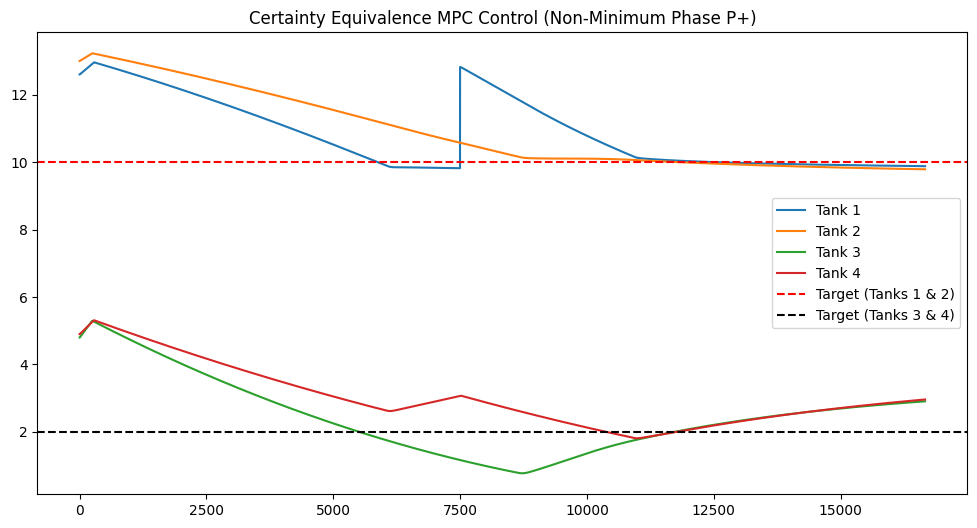

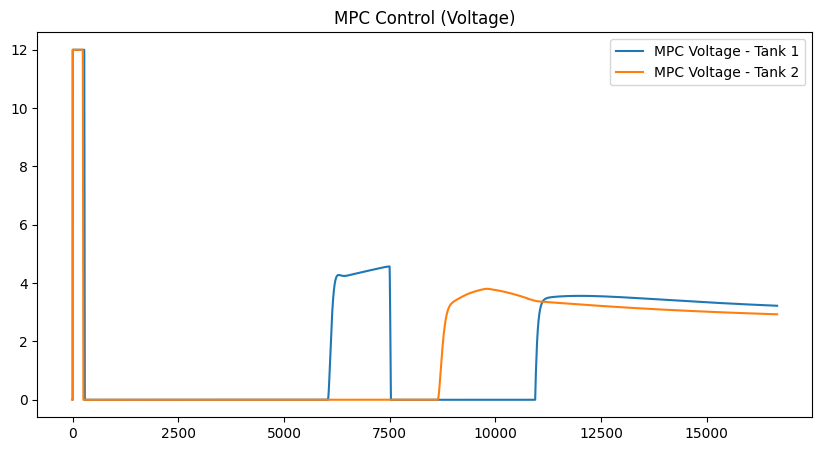

In [ ]:
import struct
import serial
import time
import matplotlib.pyplot as plt

dt_hil = 0.003
total_time = 50.0 # seconds
steps = int(total_time / dt_hil) # 16,666 steps

# 'ffff' means 4 floats (little endian)
# The Nucleo is usually Little Endian.
packer = struct.Struct('<ffff') 
unpacker = struct.Struct('<fff')
ser = serial.Serial(SERIAL_PORT, 921600, timeout=1.0) 
print(f"✅ Connected to {ser.name}")

def send_state(ser, state_vector):
    # Add a header byte (e.g., 0xA5) so the Nucleo knows where the packet starts
    packet = b'\xA5' + packer.pack(*state_vector)
    ser.write(packet)

def receive_control_with_time(ser):
    # Read 12 bytes (3 floats)
    data = ser.read(12)
    if len(data) == 12:
        return unpacker.unpack(data)
    return (0.0, 0.0, 0.0)

# --- HIL CONTROL LOOP ---
# This replaces the internal Python calculation with the Nucleo's answer

x_test = np.array([12.6, 13.0, 4.8, 4.9]) # Start State
history_hil = []
control_history = []
exec_time = []

print("Starting Hardware-in-the-Loop Simulation...")

try:
    # Open Port (if not already open)
    if not ser.is_open:
        ser.open()
        
    for k in range(steps):
        # Disturbance!
        if k == 7500:
            x_test[0] += 3.0
            print(f"--- [Step {k}] DISTURBANCE INJECTED: h1 + 3.0 cm ---")
        
        # 1. Send State to Nucleo
        # Nucleo calculates: EKF -> KAN -> Clamp -> u
        send_state(ser, x_test)
        
        # 2. Receive Control from Nucleo
        u_nucleo = receive_control_with_time(ser)
        
        # 3. Simulate Physics (Python side)
        # We use the voltage DECIDED by the Nucleo to evolve the physics
        u1, u2, t_exec = u_nucleo
        u_applied = np.array([u1, u2])
        x_test = physics_nonlinear_model(x_test, u_applied, dt_hil)
        
        # Store data
        history_hil.append(x_test)
        control_history.append(u_applied)
        exec_time.append(t_exec)
        
        if k % 1000 == 0:
            print(f"Step {k}: h1={x_test[0]:.2f}, h2={x_test[1]:.2f}, h3={x_test[2]:.2f}, h4={x_test[3]:.2f}, u={u_applied}, execution_time={t_exec}")
    history_hilc = np.array(history_hil)
    control_historyc = np.array(control_history)
    print("HIL Complete.")
    plt.figure(figsize=(12, 6))
    plt.plot(history_hilc[:,0], label='Tank 1')
    plt.plot(history_hilc[:,1], label='Tank 2')
    plt.plot(history_hilc[:,2], label='Tank 3')
    plt.plot(history_hilc[:,3], label='Tank 4')
    plt.axhline(10.0, color='r', linestyle='--', label='Target (Tanks 1 & 2)')
    plt.axhline(2, color='k', linestyle='--', label='Target (Tanks 3 & 4)')
    plt.legend()
    plt.title("Certainty Equivalence MPC Control (Non-Minimum Phase P+)")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(control_historyc[:,0], label='MPC Voltage - Tank 1')
    plt.plot(control_historyc[:,1], label='MPC Voltage - Tank 2')
    plt.legend()
    plt.title("MPC Control (Voltage)")
    plt.show()
    
    ser.close()

except Exception as e:
    print(f"Error: {e}")
    ser.close()

# Plotting code here...

In [ ]:
import pandas as pd

# Create a DataFrame for the HIL data
df_hil = pd.DataFrame(history_hil, columns=['h1', 'h2', 'h3', 'h4'])
df_ctrl = pd.DataFrame(control_history, columns=['u1', 'u2'])
df_exec = pd.DataFrame(exec_time, columns=['t_exec'])

# Merge and Save
df_final = pd.concat([df_hil, df_ctrl, df_exec], axis=1)
df_final.to_csv('DisturbanceHandling_MPC.csv', index=False)
print("HIL Data Secured. The gold is in the vault.")

HIL Data Secured. The gold is in the vault.


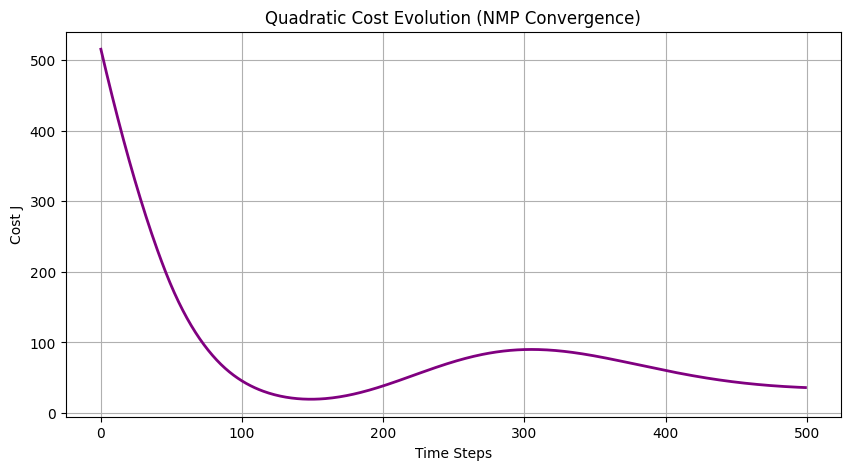

In [6]:
# Lyapunov Function (Cost) over time
lyapunov_history = []
target_state = [10.0, 10.0, 2.0, 2.0]

for k in range(len(history_kan)):
    x_err = history_kan[k] - target_state
    
    # technically u_err = u - u_steady, but u itself is fine for showing convergence
    u_val = voltage_kan[k] 
    
    # J = x^TQx + u^TRu
    cost_x = x_err.T @ Q_mpc @ x_err
    cost_u = u_val.T @ R_mpc @ u_val
    
    V_k = cost_x + cost_u
    lyapunov_history.append(V_k)

plt.figure(figsize=(10, 5))
plt.plot(lyapunov_history, linewidth=2, color='purple')
plt.title("Quadratic Cost Evolution (NMP Convergence)")
plt.xlabel("Time Steps")
plt.ylabel("Cost J")
plt.grid()
plt.yscale('linear') 
plt.show()

In [13]:
import pandas as pd

quad_cost = pd.DataFrame({
    "time_sec": np.arange(steps) * dt,
    "cost": np.array(lyapunov_history)
})

filename = 'quad_cost_history.csv'
quad_cost.to_csv(filename, index=False)

print("Successfully exported!")

    

Successfully exported!
